# **Importing Packages**

In [ ]:
!pip install pyspark demoji tqdm matplotlib wordcloud

In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,col,regexp_replace
from pyspark.sql.types import StringType
import re
import numpy as np
import demoji
import unicodedata
from tqdm import tqdm
from wordcloud import WordCloud
import concurrent.futures
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import Tokenizer,StopWordsRemover,HashingTF,IDF,StringIndexer,NGram,VectorAssembler
from pyspark.ml import Pipeline
from sklearn.metrics import classification_report
from pyspark.ml.classification import NaiveBayes,DecisionTreeClassifier,RandomForestClassifier,LogisticRegression,GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Spark & Dataset**

In [ ]:
spark=SparkSession.builder.master("local[*]").appName("BDA_MINI_PROJECT").getOrCreate()
print(spark)

In [ ]:
df1=spark.read.csv("/content/drive/MyDrive/BDA/tam-sentiment-dev.csv",header=True,inferSchema=True)
df2=spark.read.csv("/content/drive/MyDrive/BDA/tam-sentiment-train.csv",header=True,inferSchema=True)
df1.show()
df2.show()

+--------------------+--------------+
|                text|      category|
+--------------------+--------------+
|@0:40 songsuperb....| unknown_state|
|கணத்ததோர் அகமுடைய...|      Positive|
|Thalavia neenga v...|      Positive|
|Oru padam patha f...|      Positive|
|Hairstyle than ma...| unknown_state|
|பெண் பிள்ளைகளை  ப...|Mixed_feelings|
|School competitio...|      Positive|
|கொங்கு நாட்டு மக்...| unknown_state|
|I am sri lanka bu...|      Positive|
|Last dialogue sem...|      Positive|
|தேவந்திரகுல மக்கள...|      Positive|
|worst trailer i e...|      Negative|
|Views 56k ku katt...|Mixed_feelings|
|Sema yaara ematha...|Mixed_feelings|
|Trending ku late ...|      Positive|
|பரியேறும் பெருமாள...|      Positive|
|புத்தி கேட்ட மனசு...| unknown_state|
|Yov pande nee ena...|      Positive|
|Sema trailer   fu...| unknown_state|
|Kris’s movie pola...|      Positive|
+--------------------+--------------+
only showing top 20 rows

+--------------------+--------------+
|                text|  

# **Data Preprocessing**

In [ ]:
print("shape of df1 : ",df1.toPandas().shape)
print("shape of df2 : ",df2.toPandas().shape)

shape of df1 :  (3786, 2)
shape of df2 :  (33989, 2)


In [ ]:
df=df2.union(df1)
print("shape of df : ",df.toPandas().shape)

shape of df :  (37775, 2)


In [ ]:
df.show()

+--------------------+--------------+
|                text|      category|
+--------------------+--------------+
|Vani bhojam fans ...| unknown_state|
|I love you ajith ...|      Positive|
|ennaya trailer Ku...|      Positive|
|Vijay Annaa  Ur M...|      Positive|
|நம்ப நடே நாசாமா த...|      Negative|
|Gommala...Ending ...|      Positive|
|Vjs Anna kaaga li...| unknown_state|
|Theri!!! Semma Th...|      Positive|
|Ithu yethu maathi...|      Positive|
|Wow! Back to Baas...|      Negative|
|it not vijay hair...|Mixed_feelings|
|2018 la intha tea...| unknown_state|
|சாதி இல்லனா தமிழ்...| unknown_state|
|ஆண்ட சாதி, ஆண்ட ச...|Mixed_feelings|
|Please support fr...| unknown_state|
|Thala mass song  ...|      Positive|
|டேய் பா ரஞ்சித் ந...|      Positive|
|kullan fans comme...| unknown_state|
|Thaaaaaa vera lev...|      Positive|
|Arjun sir kaage p...|      Positive|
+--------------------+--------------+
only showing top 20 rows



**Cleaning Text**


In [ ]:
def clean_text(text):
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove special characters and retain alphanumeric words
    text = ' '.join(word for word in text.split() if word.isalnum() or re.search(r'[^\x00-\x7F]+', word))
    # Remove extra whitespaces and trim
    text = ' '.join(text.split())
    # Remove emojis using the 'demoji' library
    text = demoji.replace(text, '')
    # Remove sequences of the same character
    text = re.sub(r'(.)\1{3,}', r'\1\1', text)
    # Convert text to lowercase
    text = text.lower()
    return text

In [ ]:
# Register the UDF
clean_text_udf = udf(clean_text, StringType())
# Apply the UDF to the specified column and create a new cleaned column
df = df.withColumn('cleaned_text', clean_text_udf(df["text"]))

In [ ]:
df.show()

+--------------------+--------------+--------------------+
|                text|      category|        cleaned_text|
+--------------------+--------------+--------------------+
|Vani bhojam fans ...| unknown_state|vani bhojam fans ...|
|I love you ajith ...|      Positive|i love you ajith ...|
|ennaya trailer Ku...|      Positive|ennaya trailer ku...|
|Vijay Annaa  Ur M...|      Positive|vijay annaa ur ma...|
|நம்ப நடே நாசாமா த...|      Negative|நம்ப நடே நாசாமா த...|
|Gommala...Ending ...|      Positive|  vera level da deii|
|Vjs Anna kaaga li...| unknown_state|vjs anna kaaga li...|
|Theri!!! Semma Th...|      Positive|semma joseph kuru...|
|Ithu yethu maathi...|      Positive|ithu yethu maathi...|
|Wow! Back to Baas...|      Negative|back to baasha pa...|
|it not vijay hair...|Mixed_feelings|it not vijay hair...|
|2018 la intha tea...| unknown_state|la intha teaser a...|
|சாதி இல்லனா தமிழ்...| unknown_state|சாதி இல்லனா தமிழ்...|
|ஆண்ட சாதி, ஆண்ட ச...|Mixed_feelings|ஆண்ட சாதி, ஆண்ட ச..

In [ ]:
print("shape of df : ",df.toPandas().shape)

shape of df :  (37775, 3)


**Tamil Translation**

In [ ]:
# columns_to_drop = ["text"]
# df = df.drop(*columns_to_drop)
# df1=df.toPandas()
# df1.to_csv("final1.csv", index=False)
# df=pd.read_csv("/content/final1.csv")
# rows_per_file = 4000

# # Split the DataFrame into smaller DataFrames based on the condition
# smaller_dfs = [df[i:i + rows_per_file] for i in range(0, len(df), rows_per_file)]

# # Specify a base output filename
# output_base_filename = 'output_file'

# # Save each smaller DataFrame as a separate CSV file
# for i, smaller_df in enumerate(smaller_dfs):
#     output_filename = f"{output_base_filename}_{i}.csv"
#     smaller_df.to_csv(output_filename, index=False)

In [ ]:
# pip install googletrans==4.0.0-rc1
# from googletrans import Translator
# import pandas as pd

# # Initialize the translator
# translator = Translator()

# # Load the CSV file with Tanglish text (replace 'input.csv' with your file path)
# df = pd.read_csv('/content/output_file_6.csv')
# # Function to translate Tanglish to Tamil
# def tanglish_to_tamil(text):
#     try:
#         translated = translator.translate(text, src='en', dest='ta')
#         return translated.text
#     except Exception as e:
#         return str(e)
# # Apply the translation function to the 'tanglish_text' column with tqdm
# tqdm.pandas()  # Enable tqdm progress tracking

# # Use progress_apply instead of apply for tqdm progress
# df['tamil_text'] = df['cleaned_text'].progress_apply(tanglish_to_tamil)

# # Save the DataFrame to a new CSV file with Tamil text (replace 'output.csv' with your desired file path)
# df.to_csv('output6.csv', index=False)

# print("Conversion complete. Tamil CSV file saved as 'output.csv'")


In [ ]:
df1=spark.read.csv("/content/drive/MyDrive/BDA/TRANSFORM/output0.csv",header=True,inferSchema=True)
df2=spark.read.csv("/content/drive/MyDrive/BDA/TRANSFORM/output1.csv",header=True,inferSchema=True)
df3=spark.read.csv("/content/drive/MyDrive/BDA/TRANSFORM/output2.csv",header=True,inferSchema=True)
df4=spark.read.csv("/content/drive/MyDrive/BDA/TRANSFORM/output3.csv",header=True,inferSchema=True)
df5=spark.read.csv("/content/drive/MyDrive/BDA/TRANSFORM/output4.csv",header=True,inferSchema=True)
df6=spark.read.csv("/content/drive/MyDrive/BDA/TRANSFORM/output5.csv",header=True,inferSchema=True)
df7=spark.read.csv("/content/drive/MyDrive/BDA/TRANSFORM/output6.csv",header=True,inferSchema=True)
df8=spark.read.csv("/content/drive/MyDrive/BDA/TRANSFORM/output7.csv",header=True,inferSchema=True)
df9=spark.read.csv("/content/drive/MyDrive/BDA/TRANSFORM/output8.csv",header=True,inferSchema=True)
df10=spark.read.csv("/content/drive/MyDrive/BDA/TRANSFORM/output9.csv",header=True,inferSchema=True)

In [ ]:
df = df1.union(df2).union(df3).union(df4).union(df5).union(df6).union(df7).union(df8).union(df9).union(df10)

In [ ]:
print("shape of df : ",df.toPandas().shape)

shape of df :  (37775, 3)


In [ ]:
df.show()

+--------------+--------------------+--------------------+
|      category|        cleaned_text|          tamil_text|
+--------------+--------------------+--------------------+
| unknown_state|vani bhojam fans ...|வானி போஜன் ரசிகர்...|
|      Positive|i love you ajith ...|நான் உன்னை விரும்...|
|      Positive|ennaya trailer ku...|என்னாயா டிரெய்லர்...|
|      Positive|vijay annaa ur ma...|விஜய் அண்ணா உர் ம...|
|      Negative|நம்ப நடே நாசாமா த...|     நம்ப நடே நாசாமா|
|      Positive|  vera level da deii|    வேரா லெவல் டா டீ|
| unknown_state|vjs anna kaaga li...|வி.ஜே.எஸ் அண்ணா க...|
|      Positive|semma joseph kuru...|செம்மா ஜோசப் குரு...|
|      Positive|ithu yethu maathi...|ithu yethu maathi...|
|      Negative|back to baasha pa...| மீண்டும் பாஷா பராக்|
|Mixed_feelings|it not vijay hair...|இது விஜய் முடி மு...|
| unknown_state|la intha teaser a...|லா இன்டா டீஸர் பன...|
| unknown_state|சாதி இல்லனா தமிழ்...|சாதி இல்லனா தமிழ்...|
|Mixed_feelings|ஆண்ட சாதி, ஆண்ட ச...|ஆண்ட சாதி, ஆண்ட ச..

In [ ]:
def remove_non_tamil_characters(text):
    # Define a regular expression pattern to match Tamil characters and spaces
    tamil_pattern = re.compile(r'[\u0B80-\u0BFF\s]')

    # Use the pattern to find and join Tamil characters and spaces
    tamil_text = ''.join(tamil_pattern.findall(text))

    return tamil_text

In [ ]:
# Register the UDF
remove_non_tamil_characters_udf = udf(remove_non_tamil_characters, StringType())

In [ ]:
# Assuming 'text_column' is the name of the column containing text
df = df.withColumn('tamil_cleaned', remove_non_tamil_characters_udf(df['tamil_text']))

In [ ]:
df.show()

+--------------+--------------------+--------------------+--------------------+
|      category|        cleaned_text|          tamil_text|       tamil_cleaned|
+--------------+--------------------+--------------------+--------------------+
| unknown_state|vani bhojam fans ...|வானி போஜன் ரசிகர்...|வானி போஜன் ரசிகர்...|
|      Positive|i love you ajith ...|நான் உன்னை விரும்...|நான் உன்னை விரும்...|
|      Positive|ennaya trailer ku...|என்னாயா டிரெய்லர்...|என்னாயா டிரெய்லர்...|
|      Positive|vijay annaa ur ma...|விஜய் அண்ணா உர் ம...|விஜய் அண்ணா உர் ம...|
|      Negative|நம்ப நடே நாசாமா த...|     நம்ப நடே நாசாமா|     நம்ப நடே நாசாமா|
|      Positive|  vera level da deii|    வேரா லெவல் டா டீ|    வேரா லெவல் டா டீ|
| unknown_state|vjs anna kaaga li...|வி.ஜே.எஸ் அண்ணா க...|விஜேஎஸ் அண்ணா காக...|
|      Positive|semma joseph kuru...|செம்மா ஜோசப் குரு...|செம்மா ஜோசப் குரு...|
|      Positive|ithu yethu maathi...|ithu yethu maathi...|                    |
|      Negative|back to baasha pa...| மீ

In [ ]:
columns_to_drop = ["cleaned_text","tamil_text"]
df = df.drop(*columns_to_drop)

In [ ]:
print("shape of df : ",df.toPandas().shape)

shape of df :  (37775, 2)


In [ ]:
df.show()

+--------------+--------------------+
|      category|       tamil_cleaned|
+--------------+--------------------+
| unknown_state|வானி போஜன் ரசிகர்...|
|      Positive|நான் உன்னை விரும்...|
|      Positive|என்னாயா டிரெய்லர்...|
|      Positive|விஜய் அண்ணா உர் ம...|
|      Negative|     நம்ப நடே நாசாமா|
|      Positive|    வேரா லெவல் டா டீ|
| unknown_state|விஜேஎஸ் அண்ணா காக...|
|      Positive|செம்மா ஜோசப் குரு...|
|      Positive|                    |
|      Negative| மீண்டும் பாஷா பராக்|
|Mixed_feelings|இது விஜய் முடி மு...|
| unknown_state|லா இன்டா டீஸர் பன...|
| unknown_state|சாதி இல்லனா தமிழ்...|
|Mixed_feelings|ஆண்ட சாதி ஆண்ட சா...|
| unknown_state|நண்பர்களுக்கு எனத...|
|      Positive|தாலா மாஸ் பாடல் எ...|
|      Positive|டேய் பா ரஞ்சித் ந...|
| unknown_state|குல்லன் ரசிகர்கள்...|
|      Positive|             தா வேரா|
|      Positive|அர்ஜுன் சர் கெயே ...|
+--------------+--------------------+
only showing top 20 rows



In [ ]:
tamil_unicode_pattern = u'[\u0B80-\u0BFF\s]'

# Use the filter method to keep rows that contain Tamil characters
df = df.filter(
    col("tamil_cleaned").rlike(tamil_unicode_pattern) | (col("tamil_cleaned") != "")
)

In [ ]:
print("shape of df : ",df.toPandas().shape)

shape of df :  (37719, 2)


In [ ]:
df.show()

+--------------+--------------------+
|      category|       tamil_cleaned|
+--------------+--------------------+
| unknown_state|வானி போஜன் ரசிகர்...|
|      Positive|நான் உன்னை விரும்...|
|      Positive|என்னாயா டிரெய்லர்...|
|      Positive|விஜய் அண்ணா உர் ம...|
|      Negative|     நம்ப நடே நாசாமா|
|      Positive|    வேரா லெவல் டா டீ|
| unknown_state|விஜேஎஸ் அண்ணா காக...|
|      Positive|செம்மா ஜோசப் குரு...|
|      Positive|                    |
|      Negative| மீண்டும் பாஷா பராக்|
|Mixed_feelings|இது விஜய் முடி மு...|
| unknown_state|லா இன்டா டீஸர் பன...|
| unknown_state|சாதி இல்லனா தமிழ்...|
|Mixed_feelings|ஆண்ட சாதி ஆண்ட சா...|
| unknown_state|நண்பர்களுக்கு எனத...|
|      Positive|தாலா மாஸ் பாடல் எ...|
|      Positive|டேய் பா ரஞ்சித் ந...|
| unknown_state|குல்லன் ரசிகர்கள்...|
|      Positive|             தா வேரா|
|      Positive|அர்ஜுன் சர் கெயே ...|
+--------------+--------------------+
only showing top 20 rows



In [ ]:
contains_null_values = df.filter(col("tamil_cleaned").isNull()).count()
print("Total Rows with Null Values:", contains_null_values)

Total Rows with Null Values: 0


#**Feature Extraction**

In [ ]:
tokenizer = Tokenizer(inputCol="tamil_cleaned", outputCol="tokens")

In [ ]:
# Read the Tamil stop words from the TXT file
with open('/content/drive/MyDrive/BDA/TamilStopWords.txt', 'r', encoding='utf-8') as file:
    tamil_stop_words = [line.strip() for line in file]
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_words",stopWords=tamil_stop_words)

In [ ]:
hashingTF = HashingTF(inputCol="filtered_words", outputCol="raw_features", numFeatures=37775)
idf = IDF(inputCol="raw_features", outputCol="features")

# Create a pipeline with the defined stages
pipeline = Pipeline(stages=[tokenizer,remover,hashingTF,idf])

# Fit the pipeline on the DataFrame
model = pipeline.fit(df)

# Transform the DataFrame using the fitted pipeline
df = model.transform(df)

In [ ]:
df.show()

+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      category|       tamil_cleaned|              tokens|      filtered_words|        raw_features|            features|
+--------------+--------------------+--------------------+--------------------+--------------------+--------------------+
| unknown_state|வானி போஜன் ரசிகர்...|[வானி, போஜன், ரசி...|[வானி, போஜன், ரசி...|(37775,[12420,140...|(37775,[12420,140...|
|      Positive|நான் உன்னை விரும்...|[நான், உன்னை, விர...|[உன்னை, விரும்புக...|(37775,[6974,9761...|(37775,[6974,9761...|
|      Positive|என்னாயா டிரெய்லர்...|[என்னாயா, டிரெய்ல...|[என்னாயா, டிரெய்ல...|(37775,[6452,1021...|(37775,[6452,1021...|
|      Positive|விஜய் அண்ணா உர் ம...|[விஜய், அண்ணா, உர...|[விஜய், அண்ணா, உர...|(37775,[2120,4352...|(37775,[2120,4352...|
|      Negative|     நம்ப நடே நாசாமா| [நம்ப, நடே, நாசாமா]| [நம்ப, நடே, நாசாமா]|(37775,[5007,7819...|(37775,[5007,7819...|
|      Positive|    வேரா

In [ ]:
columns= ["filtered_words","raw_features","tokens","ngrams"]
df = df.drop(*columns)

In [ ]:
df.show()

+--------------+--------------------+--------------------+
|      category|       tamil_cleaned|            features|
+--------------+--------------------+--------------------+
| unknown_state|வானி போஜன் ரசிகர்...|(37775,[12420,140...|
|      Positive|நான் உன்னை விரும்...|(37775,[6974,9761...|
|      Positive|என்னாயா டிரெய்லர்...|(37775,[6452,1021...|
|      Positive|விஜய் அண்ணா உர் ம...|(37775,[2120,4352...|
|      Negative|     நம்ப நடே நாசாமா|(37775,[5007,7819...|
|      Positive|    வேரா லெவல் டா டீ|(37775,[12858,137...|
| unknown_state|விஜேஎஸ் அண்ணா காக...|(37775,[9499,1107...|
|      Positive|செம்மா ஜோசப் குரு...|(37775,[9937,1043...|
|      Positive|                    |       (37775,[],[])|
|      Negative| மீண்டும் பாஷா பராக்|(37775,[14273,310...|
|Mixed_feelings|இது விஜய் முடி மு...|(37775,[10439,263...|
| unknown_state|லா இன்டா டீஸர் பன...|(37775,[5922,6326...|
| unknown_state|சாதி இல்லனா தமிழ்...|(37775,[2548,3011...|
|Mixed_feelings|ஆண்ட சாதி ஆண்ட சா...|(37775,[5870,8470..

In [ ]:
column_order = ["tamil_cleaned","features", "category"]
# Select the columns in the desired order
df = df.select(column_order)

In [ ]:
df.show()

+--------------------+--------------------+--------------+
|       tamil_cleaned|            features|      category|
+--------------------+--------------------+--------------+
|வானி போஜன் ரசிகர்...|(37775,[12420,140...| unknown_state|
|நான் உன்னை விரும்...|(37775,[6974,9761...|      Positive|
|என்னாயா டிரெய்லர்...|(37775,[6452,1021...|      Positive|
|விஜய் அண்ணா உர் ம...|(37775,[2120,4352...|      Positive|
|     நம்ப நடே நாசாமா|(37775,[5007,7819...|      Negative|
|    வேரா லெவல் டா டீ|(37775,[12858,137...|      Positive|
|விஜேஎஸ் அண்ணா காக...|(37775,[9499,1107...| unknown_state|
|செம்மா ஜோசப் குரு...|(37775,[9937,1043...|      Positive|
|                    |       (37775,[],[])|      Positive|
| மீண்டும் பாஷா பராக்|(37775,[14273,310...|      Negative|
|இது விஜய் முடி மு...|(37775,[10439,263...|Mixed_feelings|
|லா இன்டா டீஸர் பன...|(37775,[5922,6326...| unknown_state|
|சாதி இல்லனா தமிழ்...|(37775,[2548,3011...| unknown_state|
|ஆண்ட சாதி ஆண்ட சா...|(37775,[5870,8470...|Mixed_feeling

In [ ]:
chk=df.toPandas()
unique_count = chk['category'].nunique()
unique_count

14

In [ ]:
chk['category'].unique()

array(['unknown_state', 'Positive', 'Negative', 'Mixed_feelings',
       '" """"Garvatthoda"""" Movie kaaga"',
       '" VJ PAANS GONNA BE """"SASI"""".."', None,
       ' etho laegiyam vikiramaathri irukku""',
       '" விவசாய பிரச்சனைக்கு """"கத்தி"""""',
       '"  """""""" எல்லாதையும் தட்டி கேக்குற உரிமை இருக்கு\xa0"',
       'ஒழுங்கா படம் எடுடா முண்டம்""',
       ' Suriya anna fans laam Hit like button here""',
       ' evanum touch panna mudiyadhu.......""',
       'views update hang aayitu ennanu paarunga plz 24 minslaye 492 k views vanthutu ippom 2 hours aayitu innum 492k viewslaye irukku""',
       '"  """""""" எல்லாதையும் தட்டி கேக்குற உரிமை இருக்கு  \'\'\'\' ......  #Surya_fanz_ Club  #NGK"""'],
      dtype=object)

In [ ]:
# Define the specified values to keep
specified_values = ['unknown_state','Positive','Negative','Mixed_feelings']

# Filter the DataFrame to keep only rows with "Category" values in specified_values
filtered_df = chk[chk['category'].isin(specified_values)]

In [ ]:
filtered_df['category'].unique()

array(['unknown_state', 'Positive', 'Negative', 'Mixed_feelings'],
      dtype=object)

In [ ]:
filtered_df.shape

(37705, 3)

In [ ]:
df=spark.createDataFrame(filtered_df)

In [ ]:
df.write.parquet("sentiment.parquet", mode="overwrite")

In [ ]:
df.show()

+--------------------+--------------------+--------------+
|       tamil_cleaned|            features|      category|
+--------------------+--------------------+--------------+
|வானி போஜன் ரசிகர்...|(37775,[12420,140...| unknown_state|
|நான் உன்னை விரும்...|(37775,[6974,9761...|      Positive|
|என்னாயா டிரெய்லர்...|(37775,[6452,1021...|      Positive|
|விஜய் அண்ணா உர் ம...|(37775,[2120,4352...|      Positive|
|     நம்ப நடே நாசாமா|(37775,[5007,7819...|      Negative|
|    வேரா லெவல் டா டீ|(37775,[12858,137...|      Positive|
|விஜேஎஸ் அண்ணா காக...|(37775,[9499,1107...| unknown_state|
|செம்மா ஜோசப் குரு...|(37775,[9937,1043...|      Positive|
|                    |       (37775,[],[])|      Positive|
| மீண்டும் பாஷா பராக்|(37775,[14273,310...|      Negative|
|இது விஜய் முடி மு...|(37775,[10439,263...|Mixed_feelings|
|லா இன்டா டீஸர் பன...|(37775,[5922,6326...| unknown_state|
|சாதி இல்லனா தமிழ்...|(37775,[2548,3011...| unknown_state|
|ஆண்ட சாதி ஆண்ட சா...|(37775,[5870,8470...|Mixed_feeling

#**Visualization**

In [ ]:
# Compute the counts of each category
category_counts = df.groupBy("category").count()

In [ ]:
# Extract the category names and counts as lists
categories = category_counts.select("category").rdd.flatMap(lambda x: x).collect()
counts = category_counts.select("count").rdd.flatMap(lambda x: x).collect()

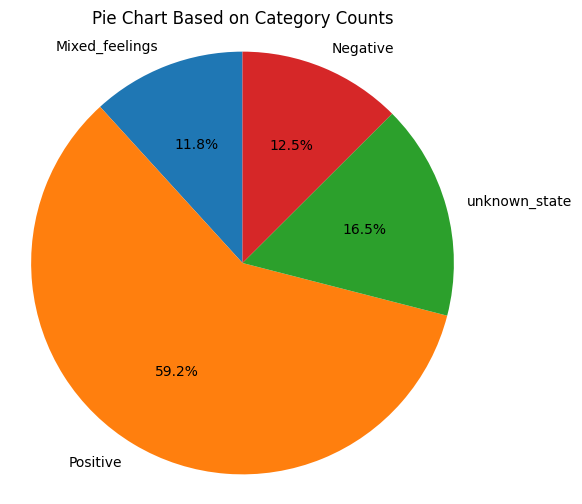

In [ ]:
# Create a pie chart
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=90)
plt.title("Pie Chart Based on Category Counts")
plt.axis('equal')

# Show the pie chart
plt.show()

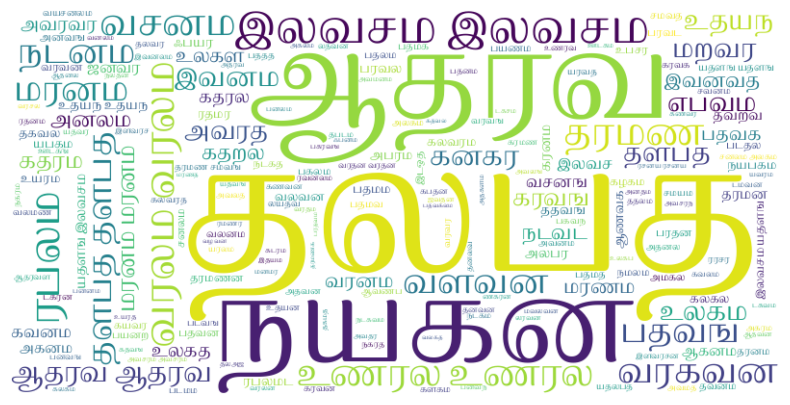

In [ ]:
# Concatenate all text data into a single string
text = ' '.join(df.select("tamil_cleaned").rdd.flatMap(lambda x: x).collect())

# Split the text into words with more than four characters
words = re.findall(r'\b\w{4,7}\b', text)

# Join the words back into a single string
text = ' '.join(words)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    font_path="/content/drive/MyDrive/BDA/Arima_Madurai.ttf",
).generate(text)

# Save the word cloud as an image file (e.g., PNG)
wordcloud.to_file("wordcloud.png")

# Display the word cloud using Matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Initialize StringIndexer with input and output columns
string_indexer = StringIndexer(inputCol="category", outputCol="label")

# Fit and transform the DataFrame to perform label encoding
df_encoded = string_indexer.fit(df).transform(df)

df_encoded = df_encoded.withColumn("label", col("label").cast("integer"))

# Show the encoded DataFrame
df_encoded.show()

+--------------------+--------------------+--------------+-----+
|       tamil_cleaned|            features|      category|label|
+--------------------+--------------------+--------------+-----+
|வானி போஜன் ரசிகர்...|(37775,[12420,140...| unknown_state|    1|
|நான் உன்னை விரும்...|(37775,[6974,9761...|      Positive|    0|
|என்னாயா டிரெய்லர்...|(37775,[6452,1021...|      Positive|    0|
|விஜய் அண்ணா உர் ம...|(37775,[2120,4352...|      Positive|    0|
|     நம்ப நடே நாசாமா|(37775,[5007,7819...|      Negative|    2|
|    வேரா லெவல் டா டீ|(37775,[12858,137...|      Positive|    0|
|விஜேஎஸ் அண்ணா காக...|(37775,[9499,1107...| unknown_state|    1|
|செம்மா ஜோசப் குரு...|(37775,[9937,1043...|      Positive|    0|
|                    |       (37775,[],[])|      Positive|    0|
| மீண்டும் பாஷா பராக்|(37775,[14273,310...|      Negative|    2|
|இது விஜய் முடி மு...|(37775,[10439,263...|Mixed_feelings|    3|
|லா இன்டா டீஸர் பன...|(37775,[5922,6326...| unknown_state|    1|
|சாதி இல்லனா தமிழ்...|(37

Positive         -   0
unknown_state    -   1
Negative         -   2
Mixed_feelings   -   3

In [ ]:
columns1= ["category"]
df = df_encoded.drop(*columns1)

In [ ]:
df.show()

+--------------------+--------------------+-----+
|       tamil_cleaned|            features|label|
+--------------------+--------------------+-----+
|வானி போஜன் ரசிகர்...|(37775,[12420,140...|    1|
|நான் உன்னை விரும்...|(37775,[6974,9761...|    0|
|என்னாயா டிரெய்லர்...|(37775,[6452,1021...|    0|
|விஜய் அண்ணா உர் ம...|(37775,[2120,4352...|    0|
|     நம்ப நடே நாசாமா|(37775,[5007,7819...|    2|
|    வேரா லெவல் டா டீ|(37775,[12858,137...|    0|
|விஜேஎஸ் அண்ணா காக...|(37775,[9499,1107...|    1|
|செம்மா ஜோசப் குரு...|(37775,[9937,1043...|    0|
|                    |       (37775,[],[])|    0|
| மீண்டும் பாஷா பராக்|(37775,[14273,310...|    2|
|இது விஜய் முடி மு...|(37775,[10439,263...|    3|
|லா இன்டா டீஸர் பன...|(37775,[5922,6326...|    1|
|சாதி இல்லனா தமிழ்...|(37775,[2548,3011...|    1|
|ஆண்ட சாதி ஆண்ட சா...|(37775,[5870,8470...|    3|
|நண்பர்களுக்கு எனத...|(37775,[2927,1534...|    1|
|தாலா மாஸ் பாடல் எ...|(37775,[2120,1219...|    0|
|டேய் பா ரஞ்சித் ந...|(37775,[14634,300...|    0|


In [ ]:
columns1= ["tamil_cleaned","category"]
df = df_encoded.drop(*columns1)

In [ ]:
df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(37775,[12420,140...|    1|
|(37775,[6974,9761...|    0|
|(37775,[6452,1021...|    0|
|(37775,[2120,4352...|    0|
|(37775,[5007,7819...|    2|
|(37775,[12858,137...|    0|
|(37775,[9499,1107...|    1|
|(37775,[9937,1043...|    0|
|       (37775,[],[])|    0|
|(37775,[14273,310...|    2|
|(37775,[10439,263...|    3|
|(37775,[5922,6326...|    1|
|(37775,[2548,3011...|    1|
|(37775,[5870,8470...|    3|
|(37775,[2927,1534...|    1|
|(37775,[2120,1219...|    0|
|(37775,[14634,300...|    0|
|(37775,[1584,7775...|    1|
|(37775,[27389,341...|    0|
|(37775,[16536,166...|    0|
+--------------------+-----+
only showing top 20 rows



In [ ]:
from pyspark.sql.functions import rand
# Add a temporary column 'rand' with random values to help in splitting
df = df.withColumn("rand", rand())

In [ ]:
# Define the split ratios (e.g., 80% training and 20% testing)
train_ratio = 0.8
test_ratio = 1.0 - train_ratio

In [ ]:
# Split the data into training and testing sets
train_data = df.filter(df["rand"] < train_ratio)
test_data = df.filter(df["rand"] >= train_ratio)

In [ ]:
# Remove the 'rand' column from the split datasets
train = train_data.drop("rand")
test = test_data.drop("rand")

In [ ]:
# Verify the size of the training and testing datasets
print("Training Data Count: ", train.count())
print("Testing Data Count: ", test.count())

Training Data Count:  30093
Testing Data Count:  7612


In [ ]:
train.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(37775,[12420,140...|    1|
|(37775,[6974,9761...|    0|
|(37775,[6452,1021...|    0|
|(37775,[12858,137...|    0|
|(37775,[9937,1043...|    0|
|       (37775,[],[])|    0|
|(37775,[10439,263...|    3|
|(37775,[5922,6326...|    1|
|(37775,[2548,3011...|    1|
|(37775,[5870,8470...|    3|
|(37775,[2120,1219...|    0|
|(37775,[14634,300...|    0|
|(37775,[1584,7775...|    1|
|(37775,[27389,341...|    0|
|(37775,[16536,166...|    0|
|(37775,[9937,1218...|    0|
|(37775,[2969,9493...|    1|
|(37775,[3977,1414...|    1|
|(37775,[3064,1904...|    0|
|(37775,[2042,5134...|    2|
+--------------------+-----+
only showing top 20 rows



In [ ]:
test.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(37775,[2120,4352...|    0|
|(37775,[5007,7819...|    2|
|(37775,[9499,1107...|    1|
|(37775,[14273,310...|    2|
|(37775,[2927,1534...|    1|
|(37775,[30522,341...|    0|
|(37775,[5441,7440...|    0|
|(37775,[2636,5656...|    0|
|(37775,[163,369,2...|    3|
|       (37775,[],[])|    1|
|       (37775,[],[])|    2|
|(37775,[17018,181...|    0|
|(37775,[3425,1107...|    0|
|(37775,[1777,4087...|    3|
|(37775,[2234,3911...|    0|
|(37775,[6539,1126...|    1|
|(37775,[4548,1331...|    2|
|(37775,[3332,5752...|    3|
|(37775,[1699,2120...|    3|
|(37775,[6824,1043...|    0|
+--------------------+-----+
only showing top 20 rows



#**ML Models**

**NAIVE BAYES ALGORITHM**

In [ ]:
nb = NaiveBayes()
param_grid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.0, 1.0, 2.0])\
    .build()

In [ ]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

In [ ]:
cross_validator = CrossValidator(estimator=nb,
                                estimatorParamMaps=param_grid,
                                evaluator=evaluator,
                                numFolds=5)

In [ ]:
cv_model = cross_validator.fit(train)
best_nb_model = cv_model.bestModel

In [ ]:
test_predictions = best_nb_model.transform(test)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(test_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.598


In [ ]:
test_predictions = test_predictions.withColumn("label", test_predictions["label"].cast("double"))

In [ ]:
test_predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(37775,[2120,1219...|  0.0|[-108.56661631457...|[0.99946899804951...|       0.0|
|(37775,[1584,7775...|  1.0|[-Infinity,-611.6...|   [0.0,1.0,0.0,0.0]|       1.0|
|(37775,[9937,1218...|  0.0|[-196.76183290450...|   [1.0,0.0,0.0,0.0]|       0.0|
|(37775,[2042,5134...|  2.0|[-384.24689018408...|[8.04712460123069...|       2.0|
|(37775,[956,1840,...|  0.0|[-608.95716054617...|   [1.0,0.0,0.0,0.0]|       0.0|
|(37775,[810,14443...|  3.0|[-Infinity,-Infin...|   [0.0,0.0,0.0,1.0]|       3.0|
|(37775,[8131,1043...|  0.0|[-Infinity,-Infin...|   [0.0,0.0,0.0,1.0]|       3.0|
|(37775,[14208,335...|  0.0|[-292.59528535388...|[1.0,0.0,0.0,5.57...|       0.0|
|(37775,[2773,4505...|  1.0|[-Infinity,-440.2...|   [0.0,1.0,0.0,0.0]|       1.0|
|(37775,[2120,11

In [ ]:
# Define a function for plotting the confusion matrix
def plot_confusion_matrix(confusion_matrix, class_labels):
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap("viridis"))
    plt.title("Confusion Matrix")
    plt.colorbar()

    # Add labels to the axes
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels)
    plt.yticks(tick_marks, class_labels)

    # Add text inside the matrix
    for i in range(len(class_labels)):
        for j in range(len(class_labels)):
            plt.text(j, i, str(confusion_matrix[i, j]), ha="center", va="center", color="white")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


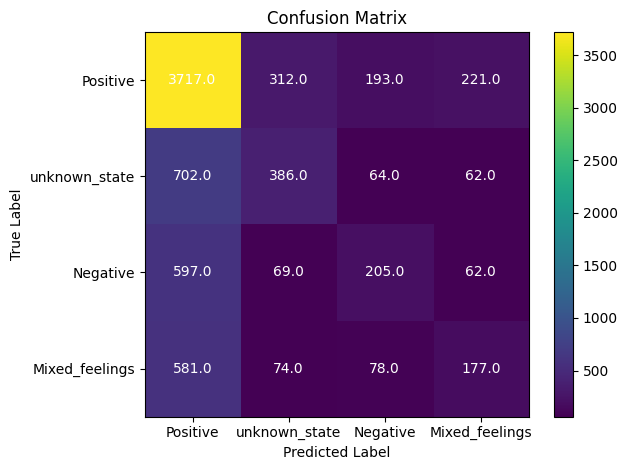

In [ ]:
# Calculate the confusion matrix
predictionAndLabels = test_predictions.select("prediction", "label")
metrics = MulticlassMetrics(predictionAndLabels.rdd)
confusion_matrix = metrics.confusionMatrix().toArray()

# Define class labels
class_labels = ['Positive', 'unknown_state', 'Negative', 'Mixed_feelings']

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix, class_labels)

In [ ]:
# Convert your Spark DataFrame to a Pandas DataFrame
test_predictions_pd = test_predictions.toPandas()

# Calculate the classification report
true_labels = test_predictions_pd['label']
predicted_labels = test_predictions_pd['prediction']

class_labels = ['Positive', 'unknown_state', 'Negative', 'Mixed_feelings']
report = classification_report(true_labels, predicted_labels, target_names=class_labels)

print(report)


                precision    recall  f1-score   support

      Positive       0.66      0.84      0.74      4443
 unknown_state       0.46      0.32      0.38      1214
      Negative       0.38      0.22      0.28       933
Mixed_feelings       0.34      0.19      0.25       910

      accuracy                           0.60      7500
     macro avg       0.46      0.39      0.41      7500
  weighted avg       0.56      0.60      0.56      7500



**DECISION TREE ALGORITHM**

In [ ]:
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=5)


In [ ]:
model = dt.fit(train)

In [ ]:
test_predictions1 = model.transform(test)
accuracy1 = evaluator.evaluate(test_predictions1)
print("Accuracy:", accuracy1)

Accuracy: 0.601024697845507


In [ ]:
test_predictions1 = test_predictions1.withColumn("label", test_predictions1["label"].cast("double"))

In [ ]:
test_predictions1.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(37775,[2120,4352...|  0.0|[1632.0,86.0,52.0...|[0.86624203821656...|       0.0|
|(37775,[5007,7819...|  2.0|[13956.0,4784.0,3...|[0.54430577223088...|       0.0|
|(37775,[9499,1107...|  1.0|[13956.0,4784.0,3...|[0.54430577223088...|       0.0|
|(37775,[14273,310...|  2.0|[13956.0,4784.0,3...|[0.54430577223088...|       0.0|
|(37775,[2927,1534...|  1.0|[13956.0,4784.0,3...|[0.54430577223088...|       0.0|
|(37775,[30522,341...|  0.0|[13956.0,4784.0,3...|[0.54430577223088...|       0.0|
|(37775,[5441,7440...|  0.0|[1245.0,49.0,84.0...|[0.81372549019607...|       0.0|
|(37775,[2636,5656...|  0.0|[13956.0,4784.0,3...|[0.54430577223088...|       0.0|
|(37775,[163,369,2...|  3.0|[13956.0,4784.0,3...|[0.54430577223088...|       0.0|
|       (37775,[

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


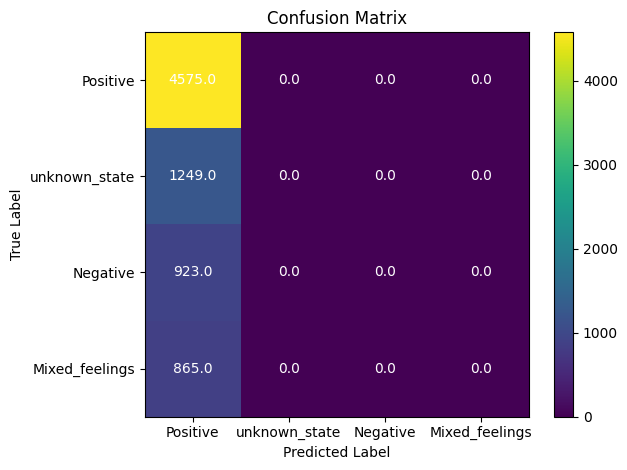

In [ ]:
# Calculate the confusion matrix
predictionAndLabels = test_predictions1.select("prediction", "label")
metrics = MulticlassMetrics(predictionAndLabels.rdd)
confusion_matrix = metrics.confusionMatrix().toArray()

# Define class labels
class_labels = ['Positive', 'unknown_state', 'Negative', 'Mixed_feelings']

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix, class_labels)

In [ ]:
# Convert your Spark DataFrame to a Pandas DataFrame
test_predictions_pd = test_predictions1.toPandas()

# Calculate the classification report
true_labels = test_predictions_pd['label']
predicted_labels = test_predictions_pd['prediction']

class_labels = ['Positive', 'unknown_state', 'Negative', 'Mixed_feelings']
report = classification_report(true_labels, predicted_labels, target_names=class_labels)

print(report)


                precision    recall  f1-score   support

      Positive       0.60      1.00      0.75      4575
 unknown_state       0.00      0.00      0.00      1249
      Negative       0.00      0.00      0.00       923
Mixed_feelings       0.00      0.00      0.00       865

      accuracy                           0.60      7612
     macro avg       0.15      0.25      0.19      7612
  weighted avg       0.36      0.60      0.45      7612



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**LOGISTIC REGRESSSION ALGORITHM**

In [ ]:
lr = LogisticRegression()
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
    .build()

In [ ]:
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
cross_validator = CrossValidator(estimator=lr,
                                estimatorParamMaps=param_grid,
                                evaluator=evaluator,
                                numFolds=5)

In [ ]:
cv_model = cross_validator.fit(train)
best_lr_model = cv_model.bestModel

In [ ]:
test_predictions3 = best_lr_model.transform(test)
accuracy3 = evaluator.evaluate(test_predictions3)
print("Accuracy:", accuracy3)

Accuracy: 0.6354666666666666


In [ ]:
test_predictions3 = test_predictions3.withColumn("label", test_predictions3["label"].cast("double"))

In [ ]:
test_predictions3.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(37775,[2120,1219...|  0.0|[1.61593056483197...|[0.72639676993953...|       0.0|
|(37775,[1584,7775...|  1.0|[0.34185029007080...|[0.12340239182617...|       1.0|
|(37775,[9937,1218...|  0.0|[1.83233224033753...|[0.79244242070214...|       0.0|
|(37775,[2042,5134...|  2.0|[0.25910011791333...|[0.16577514836965...|       2.0|
|(37775,[956,1840,...|  0.0|[4.77661638504267...|[0.99487675037737...|       0.0|
|(37775,[810,14443...|  3.0|[-0.9378279475447...|[0.01913211469419...|       3.0|
|(37775,[8131,1043...|  0.0|[1.91872478849448...|[0.75627513298150...|       0.0|
|(37775,[14208,335...|  0.0|[2.85663510610606...|[0.93751565482079...|       0.0|
|(37775,[2773,4505...|  1.0|[0.29699562026158...|[0.12021226910281...|       1.0|
|(37775,[2120,11

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


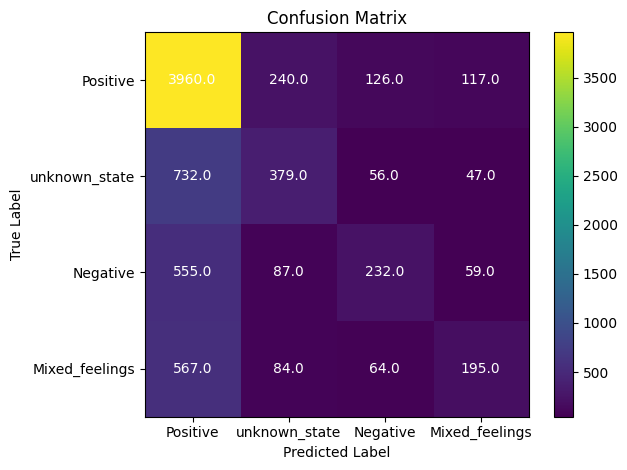

In [ ]:
# Calculate the confusion matrix
predictionAndLabels = test_predictions3.select("prediction", "label")
metrics = MulticlassMetrics(predictionAndLabels.rdd)
confusion_matrix = metrics.confusionMatrix().toArray()

# Define class labels
class_labels = ['Positive', 'unknown_state', 'Negative', 'Mixed_feelings']

# Plot the confusion matrix
plot_confusion_matrix(confusion_matrix, class_labels)

In [ ]:
# Convert your Spark DataFrame to a Pandas DataFrame
test_predictions_pd = test_predictions3.toPandas()

# Calculate the classification report
true_labels = test_predictions_pd['label']
predicted_labels = test_predictions_pd['prediction']

class_labels = ['Positive', 'unknown_state', 'Negative', 'Mixed_feelings']
report = classification_report(true_labels, predicted_labels, target_names=class_labels)

print(report)


                precision    recall  f1-score   support

      Positive       0.68      0.89      0.77      4443
 unknown_state       0.48      0.31      0.38      1214
      Negative       0.49      0.25      0.33       933
Mixed_feelings       0.47      0.21      0.29       910

      accuracy                           0.64      7500
     macro avg       0.53      0.42      0.44      7500
  weighted avg       0.60      0.64      0.60      7500



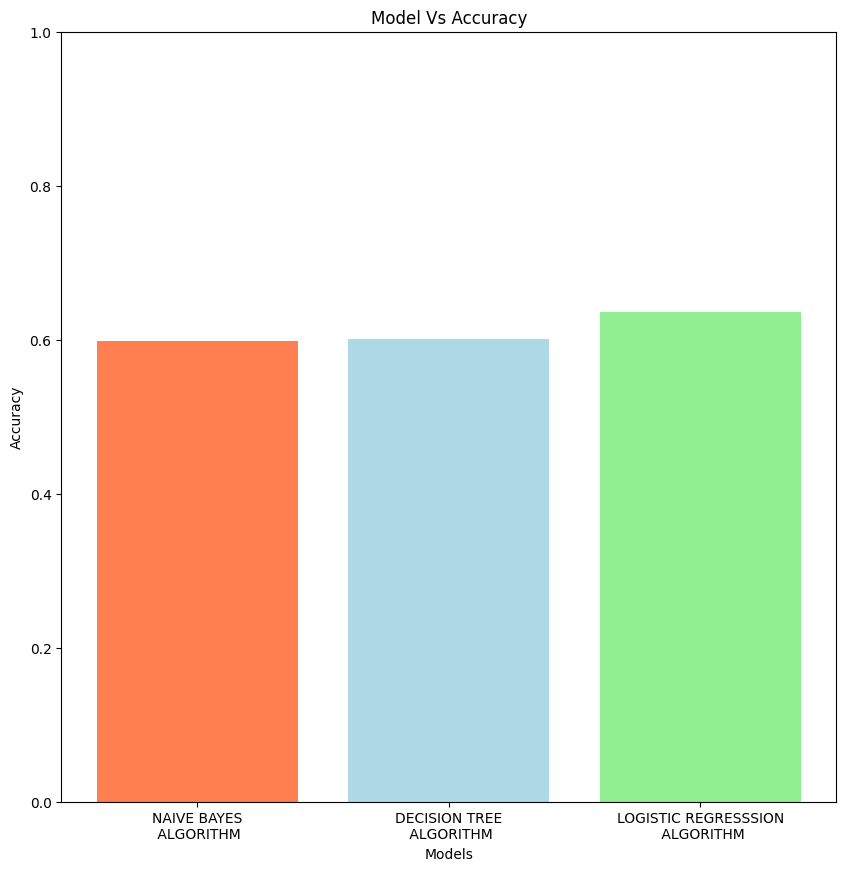

In [ ]:
import matplotlib.pyplot as plt
model_names = ['NAIVE BAYES\n ALGORITHM', 'DECISION TREE\n ALGORITHM', 'LOGISTIC REGRESSSION\n ALGORITHM']
accuracies = [accuracy,accuracy1,accuracy3]

# Create a bar graph
plt.figure(figsize=(10, 10))
plt.bar(model_names, accuracies, color=['coral', 'lightblue', 'lightgreen'])

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Vs Accuracy')


plt.ylim(0, 1.0)
plt.show()
